**Import Libraries**

from statsmodels.tsa.statespace.sarimax import SARIMAX
import mlflow
import pickle
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json

import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import json
import seaborn as sns



In [2]:
# Load your cleaned data
data = pd.read_csv('..\model\cleaned_data.csv')  

data.head(2)

,CITY,PRICE,STATE,COUNTY,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,STATEFIPS,COUNTYFIPS,LISTEDDATE,CREATEDDATE,LISTINGTYPE,ADDRESSLINE1,DAYSONMARKET,LASTSEENDATE,PROPERTYTYPE,SQUAREFOOTAGE
0,Austin,1395,TX,Travis,78758,2,30.370937,1.0,-97.699005,48,453,2025-12-04,2021-11-16,Standard,1013 Fieldwood Dr,45,2026-01-17,Multi-Family,825.0
1,Austin,2400,TX,Travis,78741,3,30.223478,2.5,-97.699338,48,453,2025-12-02,2021-09-12,Standard,6814 E Riverside Dr,47,2026-01-17,Condo,1642.0


In [3]:
# Ensure ZIPCODE is a string with leading zeros if necessary
data['ZIPCODE'] = data['ZIPCODE'].astype(str).str.zfill(5)

# Convert categorical columns to 'category' dtype
data["STATEFIPS"] = data["STATEFIPS"].astype("category")
data["COUNTYFIPS"] = data["COUNTYFIPS"].astype("category")


# Convert date columns to datetime format
date_columns = ['LISTEDDATE', 'CREATEDDATE', 'LASTSEENDATE']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')  # 'coerce' handles invalid parsing

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23791 entries, 0 to 23790
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CITY           23791 non-null  object        
 1   PRICE          23791 non-null  int64         
 2   STATE          23791 non-null  object        
 3   COUNTY         23791 non-null  object        
 4   ZIPCODE        23791 non-null  object        
 5   BEDROOMS       23791 non-null  int64         
 6   LATITUDE       23791 non-null  float64       
 7   BATHROOMS      23791 non-null  float64       
 8   LONGITUDE      23791 non-null  float64       
 9   STATEFIPS      23791 non-null  category      
 10  COUNTYFIPS     23791 non-null  category      
 11  LISTEDDATE     23791 non-null  datetime64[ns]
 12  CREATEDDATE    23791 non-null  datetime64[ns]
 13  LISTINGTYPE    23791 non-null  object        
 14  ADDRESSLINE1   23791 non-null  object        
 15  DAYSONMARKET   2379

**Market Reference - Benchmark Generation**

In [4]:
# Create and save averages of PRICE by ZIPCODE and PROPERTYTYPE
ref_averages = {
    "zipcode": data.groupby("ZIPCODE")["PRICE"].mean().to_dict(),
    "propertytype": data.groupby("PROPERTYTYPE")["PRICE"].mean().to_dict()
}

with open("../model/reference_averages.json", "w") as f:
    json.dump(ref_averages, f, indent=4)


In [25]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm


# Suppose df is your DataFrame and these are the numeric predictors you're analyzing
numeric_features = ['SQUAREFOOTAGE', 'BEDROOMS', 'BATHROOMS', 'LATITUDE', 'LONGITUDE']

# Drop rows with missing values in the selected columns (if any)
df_vif = data[numeric_features].dropna()

# Add constant for intercept
df_vif = sm.add_constant(df_vif)

# Compute VIF DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif_data)


         feature        VIF
0          const  92.015112
1  SQUAREFOOTAGE   3.388415
2       BEDROOMS   2.733190
3      BATHROOMS   2.225343
4       LATITUDE   1.026313
5      LONGITUDE   1.023711


**Analysis:**

Correlation matrix is great for spotting potential issues quickly but VIF is better for confirming and quantifying the multicollinearity across multiple predictors. The threshold guidelines: VIF of 1 to 2 (No multicollinearity concern), 2 to 5 (Moderate multicollinearity and usually acceptable), 5 to 10 (High multicollinearity which must be investigated or ensure feature removal) and > 10	(Very high multicollinearity and strong candidate for removal or transformation). 

However, all features of the dataset have VIF < 5, which is within the acceptable range for most modeling tasks. Despite prior concerns from the correlation matrix, VIF shows that no feature has dangerously high multicollinearity.

**Conclusion:** Retain all five features (SQUAREFOOTAGE, BEDROOMS, BATHROOMS, LATITUDE, LONGITUDE) in model.

**DATA LEAKAGE ASSESSMENT**

**High Risk of Data Leakage:**

a. LASTSEENDATE – Likely indicates the last time the listing was active. This correlated with the sale or delisting (i.e. may reflect price-based buyer behavior).

b. DAYSONMARKET – Derived after the listing has been on the market for some time; it's not known at the listing time and may reflect how well the price is performing.

c. ADDRESSLINE1 – Contains very specific address info and may allow the model to memorize known prices if any overlap exists with training data.

**Safe:**

a. ZIPCODE / LATITUDE / LONGITUDE / COUNTY / CITY / STATE / STATEFIPS / COUNTYFIPS – These are location indicators and are not leakage per se. The granular combinations (e.g., ZIP+lat/long) may lead to overfitting if certain neighborhoods are over-represented in the training data.

b. SQUAREFOOTAGE / BEDROOMS / BATHROOMS / PROPERTYTYPE – These are usually legitimate features for predicting price but could leak if derived post-sale. These are listed values and not appraised.

c. LISTINGTYPE – It is known at the time of listing (e.g., sale vs. rent).

d. PROPERTYTYPE – It is OK if from the original listing.

In [4]:
# Identify and drop leakage-related columns
# List of leakage-related columns to drop
leakage_columns = ['ADDRESSLINE1', 'CREATEDDATE', 'LASTSEENDATE', 'DAYSONMARKET']

# Drop them from your dataset
data = data.drop(columns=leakage_columns)

# Optional: Confirm the drop
print("Remaining columns:\n", data.columns)

Remaining columns:
 Index(['CITY', 'PRICE', 'STATE', 'COUNTY', 'ZIPCODE', 'BEDROOMS', 'LATITUDE',
       'BATHROOMS', 'LONGITUDE', 'STATEFIPS', 'COUNTYFIPS', 'LISTEDDATE',
       'LISTINGTYPE', 'PROPERTYTYPE', 'SQUAREFOOTAGE'],
      dtype='object')


**Mutual Information Regression**

In [27]:
# Copy original data
mi_data = data.copy()

# Define the feature and target matrix
X = mi_data.drop(columns=['PRICE'])
target = mi_data['PRICE']

# Convert string/object columns to category type
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Compute mutual information scores
mi_scores = mutual_info_regression(X, target, discrete_features=True, random_state=42)

# Create DataFrame of feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display the result
print(feature_importance)

          Feature  MI_Score
7       LONGITUDE  1.855117
5        LATITUDE  1.839916
3         ZIPCODE  0.722873
0            CITY  0.608047
2          COUNTY  0.532807
1           STATE  0.480104
8       STATEFIPS  0.480104
9      COUNTYFIPS  0.377158
13  SQUAREFOOTAGE  0.366911
6       BATHROOMS  0.197159
4        BEDROOMS  0.147899
12   PROPERTYTYPE  0.106084
10     LISTEDDATE  0.093989
11    LISTINGTYPE  0.003052


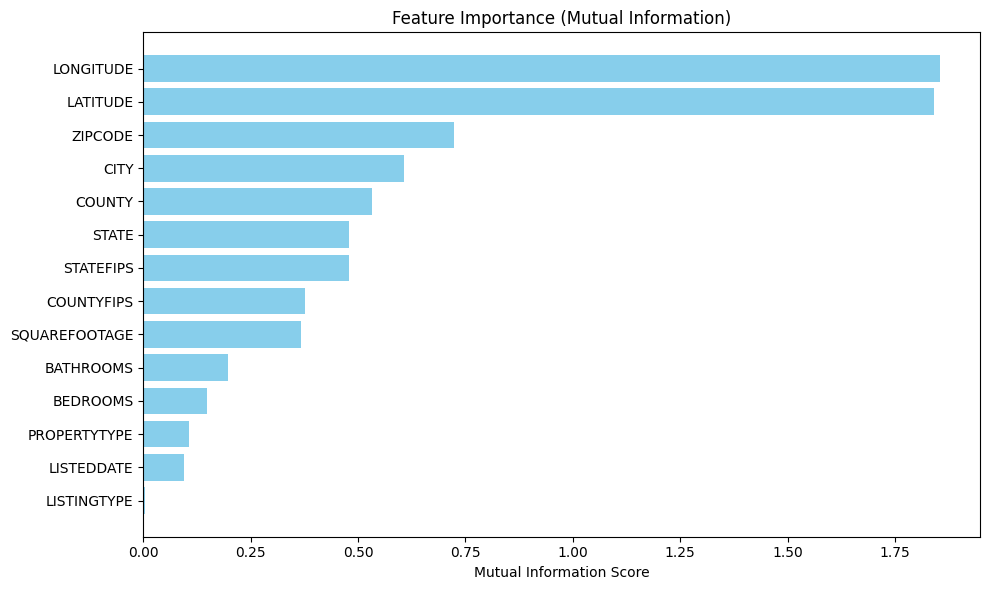

In [28]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()


**Recommendation**

1. Drop STATEFIPS and COUNTYFIPS because

a. Low MI Scores: There MI scores are relatively low compared to other location-based variables like: ZIPCODE (0.72), LATITUDE, LONGITUDE (≈ 1.8). This means STATEFIPS and COUNTYFIPS provide less unique information about PRICE.

b. Redundancy with ZIP/CITY: The inclusion of STATEFIPS or COUNTYFIPS adds redundant hierarchical data, which correlates with ZIP/CITY and adds noise to models. ZIPCODE already encodes more granular geographic information than state or county. CITY is often more interpretable and aligned with human decision-making than numeric codes like FIPS. 

2. Drop LISTINGTYPE due to Low MI Scores, low relevance and Class Imbalance issue

**Redundancy Evaluation**

In [29]:
# Count number of unique combinations and checking unique mappings
print("Unique COUNTY per CITY:", data.groupby('CITY')['COUNTY'].nunique().mean())
print("Unique COUNTY per ZIPCODE:", data.groupby('ZIPCODE')['COUNTY'].nunique().mean())

Unique COUNTY per CITY: 1.0856873822975517
Unique COUNTY per ZIPCODE: 1.0039387308533916


**Analysis**

ZIPCODE and COUNTY map is essentially one-to-one (each ZIPCODE almost always maps to a single COUNTY).

CITY and COUNTY is very close to one-to-one, with only a tiny amount of variation possibly due to rare cases of cities spanning counties.

**Recommendation** Drop the COUNTY feature due to strong one-to-one mapping with ZIPCODE and CITY (no new segmentation) and lower MI score than CITY/ZIPCODE.

In [5]:
# Drop STATEFIPS and COUNTYFIPS due to redundancy and low relevance
data = data.drop(columns=['STATEFIPS', 'COUNTYFIPS'])

# Drop LISTINGTYPE due to Low MI Scores, low relevance and Class Imbalance issue
data = data.drop(columns=['LISTINGTYPE'])

# Drop COUNTY due to redundancy with CITY/ZIPCODE and lower feature importance
data.drop(columns=['COUNTY'], inplace=True)

# Optional: Confirm remaining columns
print("Remaining columns:\n", data.columns)


Remaining columns:
 Index(['CITY', 'PRICE', 'STATE', 'ZIPCODE', 'BEDROOMS', 'LATITUDE',
       'BATHROOMS', 'LONGITUDE', 'LISTEDDATE', 'PROPERTYTYPE',
       'SQUAREFOOTAGE'],
      dtype='object')


**Feature Engineering**

In [6]:
# Log-transform skewed numeric features 
data['LOG_PRICE'] = np.log1p(data['PRICE'])
data['LOG_SQFT'] = np.log1p(data['SQUAREFOOTAGE'])

# Extract date features from LISTEDDATE
data['LISTEDDATE'] = pd.to_datetime(data['LISTEDDATE'])
data['LISTING_YEAR'] = data['LISTEDDATE'].dt.year
data['LISTING_MONTH'] = data['LISTEDDATE'].dt.month
data['LISTING_DAY'] = data['LISTEDDATE'].dt.day

data.head(2)

,CITY,PRICE,STATE,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,LISTEDDATE,PROPERTYTYPE,SQUAREFOOTAGE,LOG_PRICE,LOG_SQFT,LISTING_YEAR,LISTING_MONTH,LISTING_DAY
0,Austin,1395,TX,78758,2,30.370937,1.0,-97.699005,2025-12-04,Multi-Family,825.0,7.241366,6.716595,2025,12,4
1,Austin,2400,TX,78741,3,30.223478,2.5,-97.699338,2025-12-02,Condo,1642.0,7.783641,7.404279,2025,12,2


**Feature Encoding**

In [32]:
# List out objects in the merged dataset
data.select_dtypes(include='O').columns.tolist()

['CITY', 'STATE', 'ZIPCODE', 'PROPERTYTYPE']

In [7]:
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# Copy the original data
encode_data = data.copy()

# Define columns
nominal_columns = ['PROPERTYTYPE']  # One-hot encode
high_cardinal = ['ZIPCODE', 'CITY', 'STATE']  # Frequency encode

# 1. One-Hot Encoding for nominal columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_columns = []
for col in nominal_columns:
    transformed = ohe.fit_transform(encode_data[[col]])
    transformed_df = pd.DataFrame(transformed, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]])
    transformed_df.index = encode_data.index  # align index
    encoded_columns.append(transformed_df)

# Concatenate encoded columns
encode_data = pd.concat([encode_data] + encoded_columns, axis=1)
encode_data.drop(columns=nominal_columns, inplace=True)

# 2. Frequency Encoding for high-cardinality features
frequency_maps = {}
for col in high_cardinal:
    freq_map = encode_data[col].value_counts(normalize=True).to_dict()
    frequency_maps[col] = freq_map
    encode_data[col] = encode_data[col].map(freq_map)

# Save frequency maps for inference
with open("frequency_maps.json", "w") as f:
    json.dump(frequency_maps, f)

# Save and preview
encode_data.to_csv('encode_data.csv', index=False)
encode_data.head()


,CITY,PRICE,STATE,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,LISTEDDATE,SQUAREFOOTAGE,...,LOG_SQFT,LISTING_YEAR,LISTING_MONTH,LISTING_DAY,PROPERTYTYPE_Apartment,PROPERTYTYPE_Condo,PROPERTYTYPE_Manufactured,PROPERTYTYPE_Multi-Family,PROPERTYTYPE_Single Family,PROPERTYTYPE_Townhouse
0,0.020806,1395,0.020806,0.000883,2,30.370937,1.0,-97.699005,2025-12-04,825.0,...,6.716595,2025,12,4,0.0,0.0,0.0,1.0,0.0,0.0
1,0.020806,2400,0.020806,0.000841,3,30.223478,2.5,-97.699338,2025-12-02,1642.0,...,7.404279,2025,12,2,0.0,1.0,0.0,0.0,0.0,0.0
2,0.020806,2750,0.020806,0.000168,2,30.239952,1.0,-97.807054,2025-12-03,750.0,...,6.621406,2025,12,3,0.0,0.0,0.0,0.0,1.0,0.0
3,0.020806,1750,0.020806,0.000925,2,30.185831,1.0,-97.750809,2025-11-21,880.0,...,6.781058,2025,11,21,0.0,0.0,0.0,0.0,1.0,0.0
4,0.020806,1850,0.020806,0.000378,2,30.253058,1.0,-97.721107,2025-11-25,1135.0,...,7.035269,2025,11,25,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
data = encode_data.copy()

data.head(2)

,CITY,PRICE,STATE,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,LISTEDDATE,SQUAREFOOTAGE,...,LOG_SQFT,LISTING_YEAR,LISTING_MONTH,LISTING_DAY,PROPERTYTYPE_Apartment,PROPERTYTYPE_Condo,PROPERTYTYPE_Manufactured,PROPERTYTYPE_Multi-Family,PROPERTYTYPE_Single Family,PROPERTYTYPE_Townhouse
0,0.020806,1395,0.020806,0.000883,2,30.370937,1.0,-97.699005,2025-12-04,825.0,...,6.716595,2025,12,4,0.0,0.0,0.0,1.0,0.0,0.0
1,0.020806,2400,0.020806,0.000841,3,30.223478,2.5,-97.699338,2025-12-02,1642.0,...,7.404279,2025,12,2,0.0,1.0,0.0,0.0,0.0,0.0


LOG_PRICE (as against normal price) is the target variable

Reasons:

a. Log-transformed price was used as modeling target to address the strong right-skewness and high variance observed in the original price distribution, even after outlier capping. This transformation stabilizes variance, reduces the influence of extreme values, and improves the model’s ability to learn consistent relationships across price ranges.

b. Using LOG_PRICE also aligns with standard real‑estate modeling practice, resulting in improved predictive performance and robustness, while predictions are converted back to the original price scale to maintain business interpretability.

Train a unified pricing model, validate performance per property type.

In [ ]:
import mlflow  

# Set MLflow experiment only once per run/session (OK to keep)
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("")AlloyTower_Pricing

c:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\.venv\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location=('file:///c:/Users/USER/Desktop/Projects/Data Science/Centralized Data '
 'Platform/model/mlruns/315257353761710744'), creation_time=1769878247991, experiment_id='315257353761710744', last_update_time=1769878247991, lifecycle_stage='active', name='AlloyTower_Pricing', tags={}>

In [36]:
from sklearn.model_selection import train_test_split

# Ensure target is already log-transformed (do this once only)
data['LOG_PRICE'] = np.log1p(data['PRICE'])  # If not already done

# Feature selection
ridge_lasso_features = [
    'LOG_SQFT',
    'LATITUDE',
    'LONGITUDE',
    'LISTING_YEAR',
    'LISTING_MONTH',
    'LISTING_DAY'
]

# Define full input and target for Ridge/Lasso
X = data[ridge_lasso_features]
y = data[['PRICE', 'LOG_PRICE']]  # Needed for both training and evaluation

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Ridge Evaluation Metrics:
MAE: 611.78
MSE: 726871.53
RMSE: 852.57
MAPE: 0.3287
R²: 0.2261


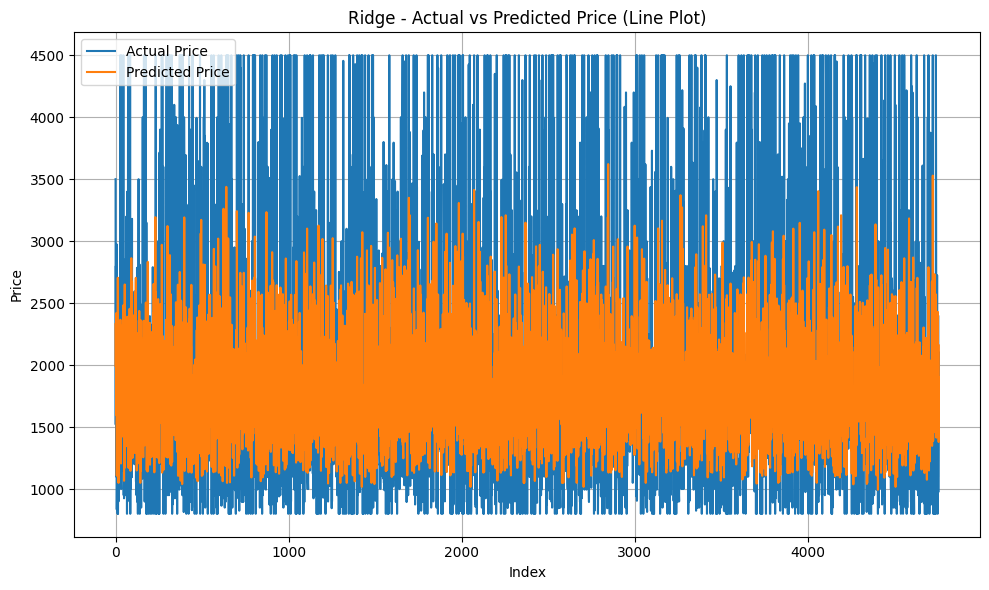


Lasso Evaluation Metrics:
MAE: 713.19
MSE: 954108.70
RMSE: 976.78
MAPE: 0.3907
R²: -0.0159


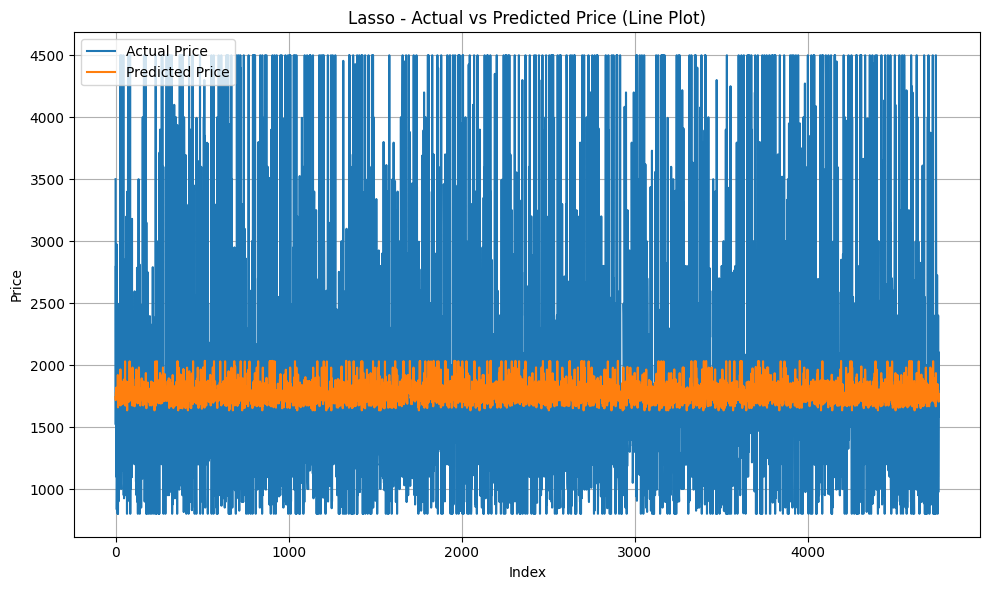

In [37]:
import pickle
import json
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Define Ridge and Lasso models
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.1, random_state=42)
}

for model_name, model in models.items():
    with mlflow.start_run(run_name=f"{model_name} Regressor"):
        # Train on log-transformed target
        model.fit(X_train, y_train['LOG_PRICE'])

        # Predict in log scale and convert back
        predicted_log = model.predict(X_test)
        predicted_price = np.expm1(predicted_log)

        # True values
        actual_price = y_test['PRICE']

        # Evaluation metrics
        mae = mean_absolute_error(actual_price, predicted_price)
        mse = mean_squared_error(actual_price, predicted_price)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(actual_price, predicted_price)
        r2 = r2_score(actual_price, predicted_price)

        # Print
        print(f"\n{model_name} Evaluation Metrics:")
        print(f"MAE: {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.4f}")
        print(f"R²: {r2:.4f}")

        # Log metrics to MLflow
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAPE", mape)
        mlflow.log_metric("R2", r2)

        # Log model hyperparameters
        mlflow.log_params(model.get_params())

        # Save and log model
        model_path = f"{model_name.lower()}_model.pkl"
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        mlflow.log_artifact(model_path)

        # Save and log input schema
        with open("features_schema.json", "w") as f:
            json.dump(X_train.columns.tolist(), f)
        mlflow.log_artifact("features_schema.json")

        # Plot line graph of actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(actual_price.values, label="Actual Price")
        plt.plot(predicted_price, label="Predicted Price")
        plt.title(f"{model_name} - Actual vs Predicted Price (Line Plot)")
        plt.xlabel("Index")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save and log plot
        plot_path = f"{model_name.lower()}_line_plot.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()


**Tree-based Model**

In [9]:
from sklearn.model_selection import train_test_split

# Define the features for tree models
tree_model_features = [ 
    'PRICE',             # Raw target for trees
    'SQUAREFOOTAGE',
    'BEDROOMS',
    'BATHROOMS',
    'LATITUDE',
    'LONGITUDE',
    'CITY',             
    'STATE',             
    'ZIPCODE',           
    'PROPERTYTYPE_Apartment',
    'PROPERTYTYPE_Condo',
    'PROPERTYTYPE_Manufactured',
    'PROPERTYTYPE_Multi-Family',
    'PROPERTYTYPE_Single Family',
    'PROPERTYTYPE_Townhouse',     
    'LISTING_YEAR',
    'LISTING_MONTH',
    'LISTING_DAY'
]

# Subset data for tree-based models
df_tree_models = data[tree_model_features].copy()

# Separate input and target
X = df_tree_models.drop(columns='PRICE')
y = df_tree_models['PRICE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.to_csv("../model/reference_data.csv", index=False)


In [39]:
print(data.columns.tolist())


['CITY', 'PRICE', 'STATE', 'ZIPCODE', 'BEDROOMS', 'LATITUDE', 'BATHROOMS', 'LONGITUDE', 'LISTEDDATE', 'SQUAREFOOTAGE', 'LOG_PRICE', 'LOG_SQFT', 'LISTING_YEAR', 'LISTING_MONTH', 'LISTING_DAY', 'PROPERTYTYPE_Apartment', 'PROPERTYTYPE_Condo', 'PROPERTYTYPE_Manufactured', 'PROPERTYTYPE_Multi-Family', 'PROPERTYTYPE_Single Family', 'PROPERTYTYPE_Townhouse']



RandomForest Evaluation
MAE : 252.87
MSE : 149378.33
RMSE: 386.49
MAPE: 0.1374
R²  : 0.8410


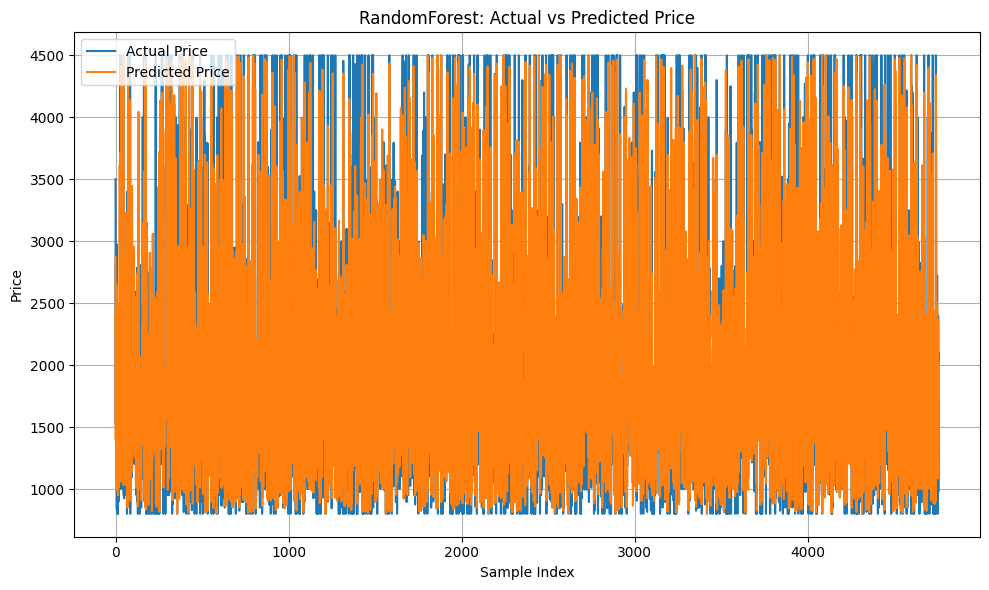


XGBoost Evaluation
MAE : 268.67
MSE : 156975.56
RMSE: 396.20
MAPE: 0.1468
R²  : 0.8329


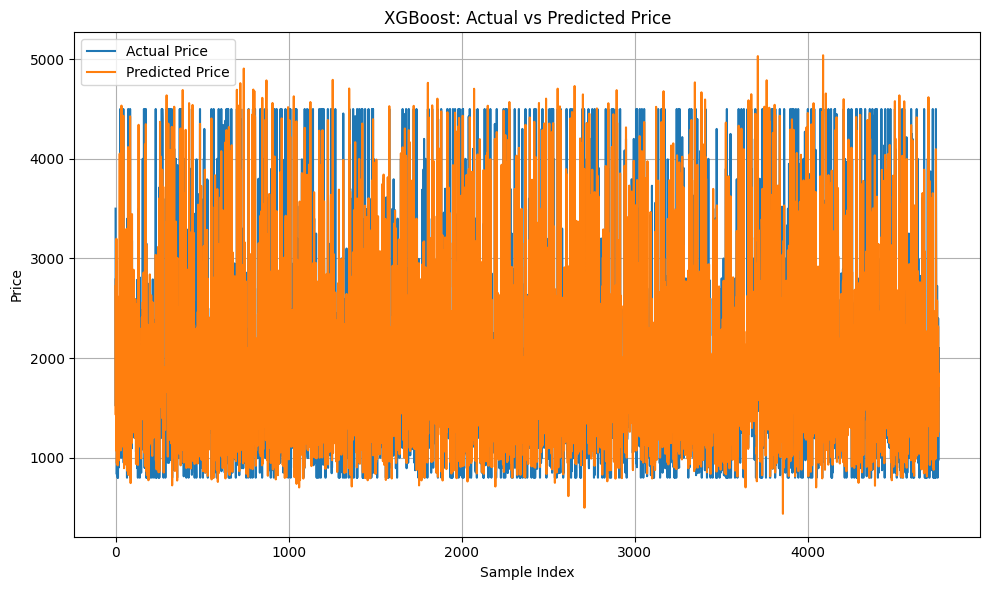


CatBoost Evaluation
MAE : 271.88
MSE : 157758.41
RMSE: 397.19
MAPE: 0.1491
R²  : 0.8320


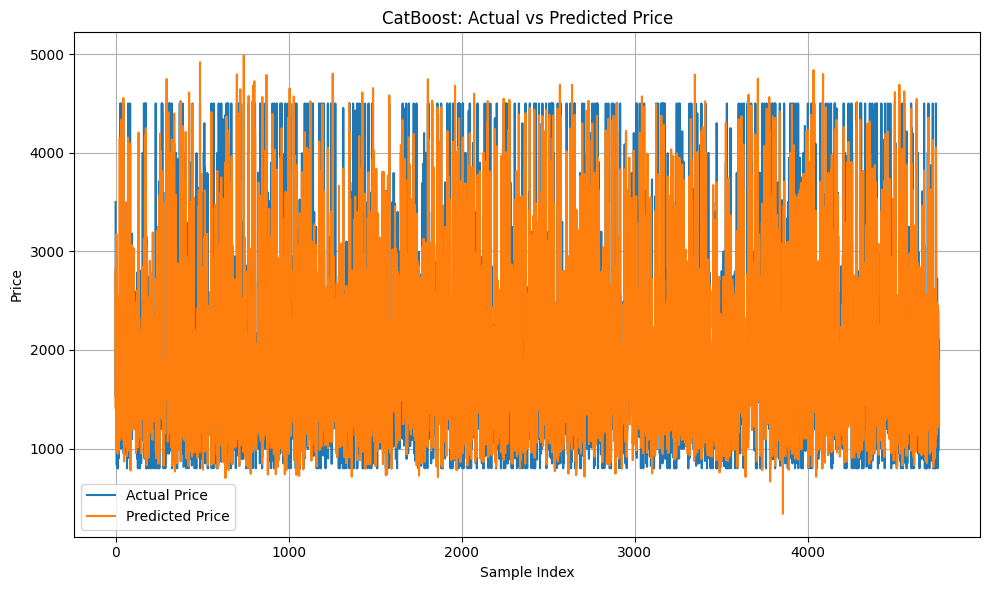

In [40]:
import pickle
import json
import mlflow
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        random_state=42,
        objective="reg:squarederror"
    ),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

for model_name, model in models.items():
    with mlflow.start_run(run_name=f"{model_name} Regressor"):

        # FIT ON RAW PRICE (Series)
        model.fit(X_train, y_train)

        # PREDICT RAW PRICE
        predicted_price = model.predict(X_test)
        actual_price = y_test

        # Metrics
        mae = mean_absolute_error(actual_price, predicted_price)
        mse = mean_squared_error(actual_price, predicted_price)
        rmse = mse ** 0.5
        mape = mean_absolute_percentage_error(actual_price, predicted_price)
        r2 = r2_score(actual_price, predicted_price)

        print(f"\n{model_name} Evaluation")
        print(f"MAE : {mae:.2f}")
        print(f"MSE : {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.4f}")
        print(f"R²  : {r2:.4f}")

        # Log metrics
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAPE", mape)
        mlflow.log_metric("R2", r2)

        # Log parameters
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())

        # Save model
        model_path = f"{model_name.lower()}_model.pkl"
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        mlflow.log_artifact(model_path)

        # Save feature schema
        with open("features_schema.json", "w") as f:
            json.dump(X_train.columns.tolist(), f)
        mlflow.log_artifact("features_schema.json")

        # LINE PLOT 
        plt.figure(figsize=(10, 6))
        plt.plot(actual_price.values, label="Actual Price")
        plt.plot(predicted_price, label="Predicted Price")
        plt.title(f"{model_name}: Actual vs Predicted Price")
        plt.xlabel("Sample Index")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plot_path = f"{model_name.lower()}_price_line_plot.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()


**Hyperparameter tuning**

**RandomForestRegressor with RandomizedSearchCV**

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\USER\Desktop\Projects\Data Science\Cent


Optimized RandomForest Evaluation
MAE : 245.68
MSE : 142090.09
RMSE: 376.95
MAPE: 0.1336
R²  : 0.8487

Best Parameters:
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 539}


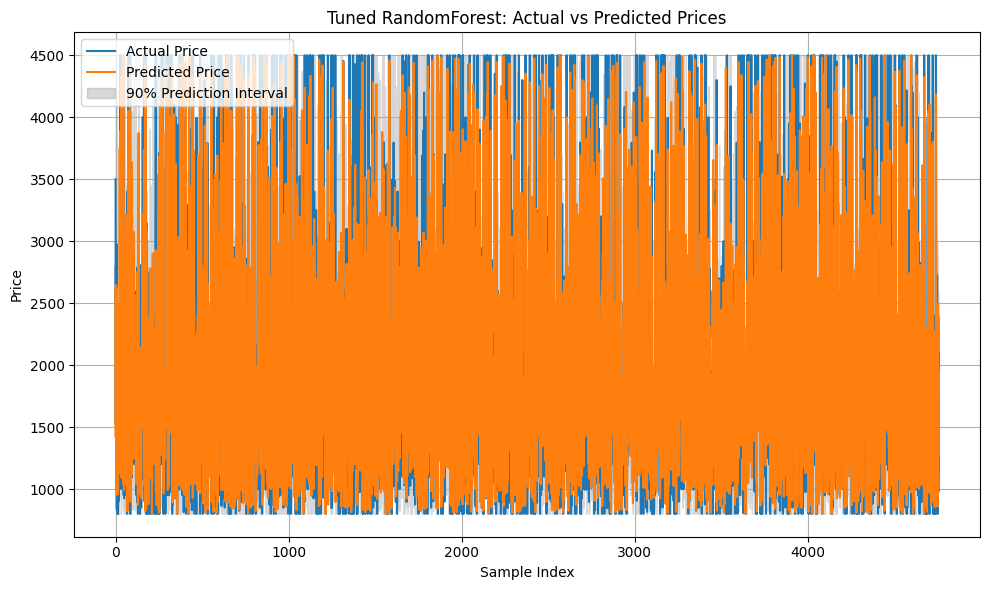

In [40]:
import pickle
import json
import mlflow
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from scipy.stats import randint

# 1. Define base RandomForest
rf = RandomForestRegressor(random_state=42)

# 2. Define hyperparameter space
param_distributions = {
    "n_estimators": randint(200, 800),
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2", 0.5],
    "bootstrap": [True, False]
}

# 3. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 4. MLflow run
with mlflow.start_run(run_name="RandomForest_Tuned"):

    # Fit model
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Point predictions
    predicted_price = best_model.predict(X_test)
    actual_price = y_test

    # 5. Compute Prediction Intervals
    all_tree_preds = np.stack([tree.predict(X_test) for tree in best_model.estimators_], axis=1)
    lower_bounds = np.percentile(all_tree_preds, 5, axis=1)
    upper_bounds = np.percentile(all_tree_preds, 95, axis=1)

    # 6. Save for inference use
    np.save("rf_tree_predictions.npy", all_tree_preds)
    mlflow.log_artifact("rf_tree_predictions.npy")

    # 7. Evaluation Metrics
    mae = mean_absolute_error(actual_price, predicted_price)
    mse = mean_squared_error(actual_price, predicted_price)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual_price, predicted_price)
    r2 = r2_score(actual_price, predicted_price)

    print("\nOptimized RandomForest Evaluation")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")
    print("\nBest Parameters:")
    print(random_search.best_params_)

    # 8. Log metrics and parameters
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("R2", r2)
    mlflow.log_params(random_search.best_params_)

    # 9. Save model
    model_path = "randomforest_tuned_model.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(best_model, f)
    mlflow.log_artifact(model_path)

    # Save feature schema
    with open("features_schema.json", "w") as f:
        json.dump(X_train.columns.tolist(), f)
    mlflow.log_artifact("features_schema.json")

    # 10. Plot with Prediction Interval
    plt.figure(figsize=(10, 6))
    plt.plot(actual_price.values, label="Actual Price")
    plt.plot(predicted_price, label="Predicted Price")
    plt.fill_between(
        range(len(predicted_price)),
        lower_bounds,
        upper_bounds,
        color='gray',
        alpha=0.3,
        label='90% Prediction Interval'
    )
    plt.title("Tuned RandomForest: Actual vs Predicted Prices")
    plt.xlabel("Sample Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plot_path = "randomforest_tuned_price_line_plot.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.show()


**Feature Importance**

In [42]:
import pandas as pd

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Save to CSV
importance_df.to_csv("feature_importance.csv", index=False)
mlflow.log_artifact("feature_importance.csv")


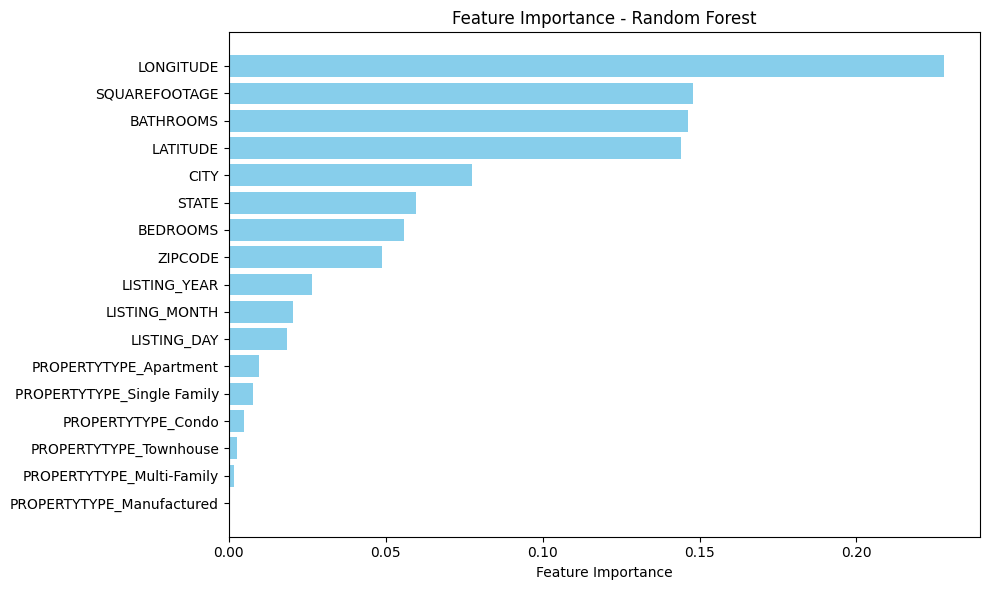

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load from CSV (if needed)
importance_df = pd.read_csv("feature_importance1.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()

# Save plot and show
plt.savefig("feature_importance_plot.png")
mlflow.log_artifact("feature_importance_plot.png")
plt.show()


**Analysis of Random Forest Feature Importance**

This is a model-specific measure based on how often and how effectively a feature reduces error (like Gini impurity or MSE) when used to split nodes in the Random Forest.

Key elements: X-axis (Importance score that sums to 1) and Y-axis (Features ranked by contribution to splits).

**Observations:**

LONGITUDE, SQUAREFOOTAGE, and BATHROOMS are the top 3.

Categorical variables like PROPERTYTYPE and LISTING_DAY have relatively low importance.

This method does not account for feature interactions or direction of influence, unlike SHAP.

**SHAP - Explainability**

In [41]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import mlflow

# Ensure your best model is from RandomizedSearchCV
best_model = random_search.best_estimator_

# Safety check before SHAP
assert X_train.columns.equals(X_test.columns), "Train/test columns mismatch"

# 1. Create SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# SAVE explainer immediately (this is what you were missing)
with open("shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

mlflow.log_artifact("shap_explainer.pkl")

# 2. Compute SHAP values
shap_values_test = explainer(X_test, check_additivity=False)

# 3. SHAP summary plot
shap.summary_plot(shap_values_test, X_test, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png")
mlflow.log_artifact("shap_summary_plot.png")
plt.close()

# 4. Save SHAP values
shap_df = pd.DataFrame(shap_values_test.values, columns=X_test.columns)
shap_df.to_csv("shap_values.csv", index=False)
mlflow.log_artifact("shap_values.csv")

# 5. Global feature importance from SHAP
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean_SHAP_Importance": np.abs(shap_values_test.values).mean(axis=0)
}).sort_values(by="Mean_SHAP_Importance", ascending=False)

importance_df.to_csv("feature_importance.csv", index=False)
mlflow.log_artifact("feature_importance.csv")

# 6. Save feature schema (VERY IMPORTANT for inference)
with open("features_schema.json", "w") as f:
    json.dump(X_train.columns.tolist(), f)

mlflow.log_artifact("features_schema.json")


100%|===================| 4757/4759 [59:12<00:01]        

**Analysis of SHAP Summary**

This is a global interpretability plot from SHAP (SHapley Additive exPlanations):

Key elements: Y-axis (Lists all features ranked by importance with top as the most important) and X-axis (SHAP value i.e. impact on the model output and values farther from zero have more influence).

Color: Shows the feature value (red = high, blue = low).

**Interpretations:**

LONGITUDE is the most important feature: The high longitude values (in red) increase the predicted price (values > 0 on X-axis). Low longitude values (blue) decrease predicted price (values < 0).

BATHROOMS, SQUAREFOOTAGE, and LATITUDE also have strong effects, with the direction of impact varying depending on the value.

SHAP captures directionality, interaction effects, and nonlinear contributions, which are not visible in standard feature importance.

**Key Comparisons & Insights from FeaturE Importance and SHAP**

Feature	                SHAP Importance	RF Importance	Notes

LONGITUDE	            High	        Highest	        Consistently top in both methods

BATHROOMS	            High	        High	        Influential in both

SQUAREFOOTAGE	        High	        High	        Consistent importance

LATITUDE	            High	        High	        Strong in both

CITY, STATE, ZIPCODE	Mid-range	    Mid-range	    Important but less than physical attributes

PROPERTYTYPE_*	        Low	            Low	            Likely weak predictors on their own

LISTING_YEAR/MONTH/DAY	Low	            Low	            Slight temporal effect

**Conclusion & Recommendation**

The two plots agree on the most influential features — especially LONGITUDE, SQUAREFOOTAGE, and BATHROOMS.

SHAP gives more nuanced insights (e.g. how high values of bathrooms increase price).

Use SHAP for interpretability, especially if sharing insights with stakeholders.

Use Random Forest importance for quick feature ranking.


In [12]:
import shap
import joblib
import pandas as pd
import pickle
import os

# Define paths
MODEL_DIR = "../model"
model_path = os.path.join(MODEL_DIR, "randomforest_tuned_model.pkl")
reference_data_path = os.path.join(MODEL_DIR, "reference_data.csv")
explainer_path = os.path.join(MODEL_DIR, "shap_explainer.joblib")

# Load model
with open(model_path, "rb") as f:
    model = pickle.load(f)

# Load reference data
X_train = pd.read_csv(reference_data_path)

# Use TreeExplainer explicitly
explainer = shap.TreeExplainer(model, X_train)

# Remove compiled model from the explainer to avoid pickle/numba issues
if hasattr(explainer, "model") and hasattr(explainer.model, "inner_model"):
    explainer.model.inner_model = None  # key part to avoid numba issue
    explainer.model = None

# Save explainer
joblib.dump(explainer, explainer_path)

print("✅ SHAP explainer saved cleanly with no compiled artifacts.")


✅ SHAP explainer saved cleanly with no compiled artifacts.
